# CSC 370 Portfolio Exercise #1

**Plant Image Classification**

This is a preliminary image classification practice of CNN. 2 different CNN architectures are applied -- one basic Keras model & AlexNet.

Dataset is private from the Kaggle BTTAI x NYBG competition platform.


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Import Data

In [ ]:
# create folder for data
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# download data
!kaggle competitions download -c bttai-nybg-2024

100% 27.7G/27.7G [20:50<00:00, 28.6MB/s]
100% 27.7G/27.7G [20:50<00:00, 23.7MB/s]


In [ ]:
# unzip file into folder|
!unzip "/content/bttai-nybg-2024.zip" -d "/content/bttai-nybg-2024"

## Make Dataset

In [ ]:
import tensorflow as tf

In [ ]:
# Load dataset & Define image directory
train_df = pd.read_csv('/content/bttai-nybg-2024/BTTAIxNYBG-train.csv')
validate_df = pd.read_csv('/content/bttai-nybg-2024/BTTAIxNYBG-validation.csv')

In [ ]:
train_df.head()

,uniqueID,classLabel,classID,source,imageFile
0,2,occluded-specimens,8,L,a1a8b48e8cb142b3.jpg
1,3,microscope-slides,6,L,79599db2ac9092b6.jpg
2,4,illustrations-color,2,BHL,c449696f2f0d0d92.jpg
3,5,illustrations-color,2,P,80a8f4a393b4e08c.jpg
4,6,animal-specimens,0,AK,041a1c6e73313638.jpg


In [ ]:
validate_df.head()

,uniqueID,classLabel,classID,source,imageFile
0,7,microscope-slides,6,K,f09a8abe9e9e9ef2.jpg
1,20,illustrations-color,2,BHL,a6c6868387c6af8c.jpg
2,37,ordinary-pressed-specimens,9,YU,6062c68e8c34b292.jpg
3,59,animal-specimens,0,CAS,363617271597dfd9.jpg
4,60,biocultural-specimens,1,Met,4218d8d2f42b05e4.jpg


bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train/8e1f2d4d613d99d1.jpg
bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train/685b4f3133260686.jpg
bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train/80a8f4a393b4e08c.jpg
bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train/4b3371737393555d.jpg
bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train/e9e16361acd0c3cb.jpg
bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train/31a0aaabaa2a2a6e.jpg
bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train/b3931bc4cc2b2925.jpg
bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train/444472d9d1d31a8c.jpg
bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train/ccf1b1ccacb8f8b3.jpg
bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train/98e2a2aeee8c9af2.jpg


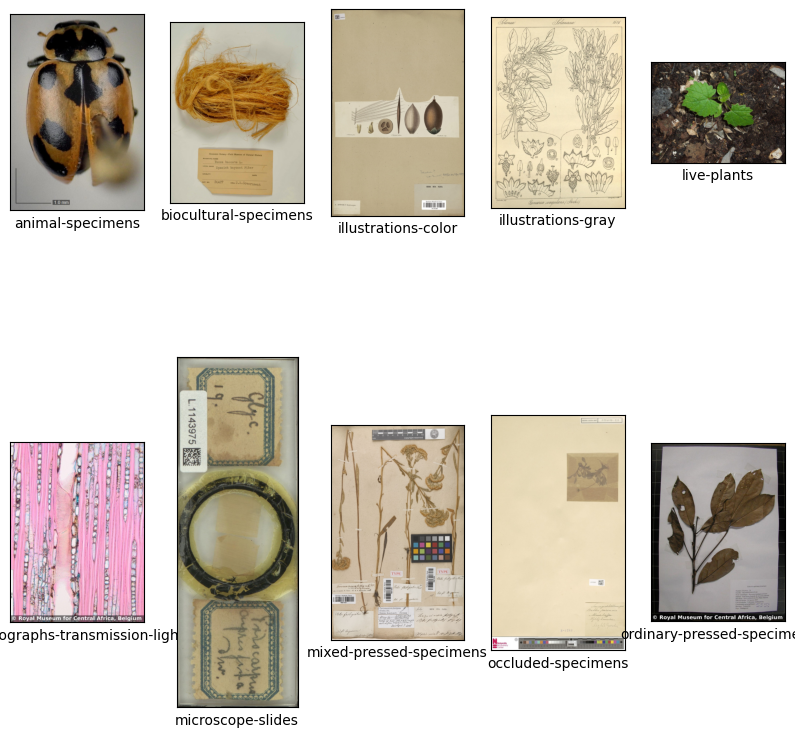

In [ ]:
# Plot Example Data
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    example = train_df.loc[train_df['classID']==i].iloc[1]
    print('bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train/' + example['imageFile'])
    image = plt.imread('bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train/' + example['imageFile'])
    plt.imshow(image)
    plt.xlabel(example['classLabel'])
plt.show()

Because the image dataset contains 80000+ entries, to faciliate model building and testing, I will only be using a small portion of the dataset at this stage.

In [ ]:
train_df = train_df.sample(frac=0.25)
validate_df = validate_df.sample(frac=0.25)

In [ ]:
# Preprocessing function to load and process images
def load_and_preprocess_image(filename,target_size=(224, 224)):
    img_path = os.path.join(image_directory, filename)
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Model expects a batch of images
    return img_array / 255.0  # Normalize to [0, 1]

In [ ]:
# # Image processing is not used in this exercise
# image_directory = 'bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train'
# train_df['imageData'] = train_df['imageFile'].apply(load_and_preprocess_image)

In [ ]:
# Data augmentation configuration for training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
# Convert dataframe to a dataset better for model feeding
image_directory = 'bttai-nybg-2024/BTTAIxNYBG-train/BTTAIxNYBG-train'
train_ds = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=image_directory,
        x_col='imageFile',
        y_col='classLabel',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 81946 validated image filenames belonging to 10 classes.


In [ ]:
# Validation image only needs rescaling as image preprocessing
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
image_directory = 'bttai-nybg-2024/BTTAIxNYBG-validation/BTTAIxNYBG-validation'
val_ds= validation_datagen.flow_from_dataframe(
        dataframe=validate_df,
        directory=image_directory,
        x_col='imageFile',
        y_col='classLabel',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 10244 validated image filenames belonging to 10 classes.


## Model Building

Reference: https://www.tensorflow.org/tutorials/images/cnn

In [ ]:
import keras
from keras.models import Sequential

from keras import layers
from keras.layers import Dense, Flatten, Dropout

from sklearn.metrics import confusion_matrix
import seaborn as sns

Model 1: basic CNN model based on Tensorflow tutorial.

Reference: https://www.tensorflow.org/tutorials/images/classification

In [ ]:
num_classes = 10

model_basic = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(224, 224, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model_basic.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model_basic.summary()
# keras.utils.plot_model(model_basic, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 28, 28, 64)       

Model 2: AlexNet

Reference: https://medium.com/swlh/alexnet-with-tensorflow-46f366559ce8

https://www.kaggle.com/code/vortexkol/alexnet-cnn-architecture-on-tensorflow-beginner

In [ ]:
alexNet = Sequential([
    layers.Conv2D(96, 11, strides=4, padding='same', input_shape=(224,224,3)),
    layers.BatchNormalization(),
    layers.MaxPool2D(3, strides=2),
    layers.Conv2D(256, 5, strides=4, padding='same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(3, strides=2),
    layers.Conv2D(256, 3, strides=4, padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(384, 3, strides=4, padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(384, 3, strides=4, padding='same'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(4096,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4096,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10,activation='softmax')
])

In [ ]:
alexNet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
alexNet.summary()
# keras.utils.plot_model(alexNet, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 56, 56, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 56, 56, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 256)         614656    
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 256)         1024      
 chNormalization)                                                
                                                      

## Model Training

In [ ]:
history_basic = model_basic.fit(train_ds, epochs=6, validation_data=val_ds)

Epoch 1/6
2561/2561 [==============================] - 6384s 2s/step - loss: 0.7632 - accuracy: 0.7298 - val_loss: 0.6786 - val_accuracy: 0.7669
Epoch 2/6
 799/2561 [========>.....................] - ETA: 1:07:22 - loss: 0.4998 - accuracy: 0.8227

In [ ]:
history_alex = alexNet.fit(train_ds, epochs=11, validation_data=val_ds)

Epoch 1/11
2561/2561 [==============================] - 5396s 2s/step - loss: 1.1470 - accuracy: 0.6156 - val_loss: 1.4324 - val_accuracy: 0.5406
Epoch 2/11
2561/2561 [==============================] - 5380s 2s/step - loss: 0.8068 - accuracy: 0.7175 - val_loss: 1.3966 - val_accuracy: 0.6274
Epoch 3/11
2561/2561 [==============================] - 5405s 2s/step - loss: 0.6726 - accuracy: 0.7616 - val_loss: 3.0185 - val_accuracy: 0.5099
Epoch 4/11
1552/2561 [=================>............] - ETA: 33:31 - loss: 0.6048 - accuracy: 0.7872

In [ ]:
# set current model and current model name for visualization
curr_model = model_basic
curr_model_name = 'Model Basic'
# curr_model = alexNet
# curr_model_name = 'AlexNet'

In [ ]:
# Plot out training accuracy and lost
curr_history = history_alex

acc = curr_history.history['accuracy']
val_acc = curr_history.history['val_accuracy']

loss = curr_history.history['loss']
val_loss = curr_history.history['val_loss']

epochs_range = range(6)

plt.figure(figsize=(10, 7.5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(curr_model_name+' Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(curr_model_name +' Training and Validation Loss')
plt.show()

## Test

*Because this Kaggle competition does not provide test label, I will use validation dataset to produce some visual evaluation.

In [ ]:
results = curr_model.evaluate(val_ds)
print("Final loss, Final accuracy:", results)

In [ ]:
# Save predicted labels & true labels
y_predictions = curr_model.predict(val_ds)
y_pred_class = [np.argmax(tf.nn.softmax(y_prediction)) for y_prediction in y_predictions] #returns the model's prediction
y_true = validate_df['classID'].to_numpy()

In [ ]:
# Generate Confusion Matrix
class_id = train_df['classID'].unique().sort() # return class IDs
class_names = ['animal-specimens','biocultural-specimens','illustrations-color','illustrations-gray','live-plants','micrographs-transmission-light','microscope-slides','mixed-pressed-specimens','occluded-specimens','ordinary-pressed-specimens'] # class labels based on classID
confusion_mtx = confusion_matrix(y_true, y_pred_class)
fig, ax = plt.subplots(figsize=(10,7.5))
ax = sns.heatmap(confusion_mtx, annot =True, fmt='d', ax=ax, cmap = 'Blues')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title(curr_model_name+' Confusion Matrix')
plt.xticks(np.arange(0.5,10), class_names)
plt.xticks(rotation=90)
plt.yticks(np.arange(0.5,10), class_id)

This part is to predict on test data

In [ ]:
test_df = pd.read_csv('/content/bttai-nybg-2024/BTTAIxNYBG-test.csv')

In [ ]:
test_df['classLabel'] = 'NaN' #placeholder to facilitate dataset generation

In [ ]:
test_df.head()

In [ ]:
image_directory = 'bttai-nybg-2024/BTTAIxNYBG-test/BTTAIxNYBG-test'
test_ds= validation_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=image_directory,
        x_col='imageFile',
        y_col='classLabel',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

In [ ]:
test_preds = model_basic.predict(test_ds)
test_pred_class = [np.argmax(tf.nn.softmax(test_pred)) for test_pred in test_preds]

In [ ]:
test_df['classID'] = test_pred_class

In [ ]:
submission = test_df[['uniqueID', 'classID']]

In [ ]:
submission.to_csv('submission.csv',index=False)

In [ ]:
import pandas as pd
submission = pd.read_csv('/content/BTTAIxNYBG-submission.csv')

In [ ]:
submission.head()

,Unnamed: 0,uniqueID,classID
0,0,1,6
1,1,9,9
2,2,10,7
3,3,14,0
4,4,16,4


In [ ]:
submission.drop(columns=['Unnamed: 0'],inplace=True)